# Summary
This tutorial demonstrates how to train an autoencoder network on MNIST hand-written characters. In this network, the output targets are the input examples, and the network is tasked with encoding each example in a low-dimensional representation which can be used to reconstruct the original input. Autoencoders are an unsupervised (without labels) approach to learning new representations of your data. 


In [1]:
import sys
import os
import pickle
import numpy
import theano
import pylearn2
import pylearn2.datasets
import pylearn2.training_algorithms
import pylearn2.training_algorithms.sgd
import pylearn2.costs
import pylearn2.models.mlp as mlp
import pylearn2.train
import pylearn2.termination_criteria
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: Tesla C2070 (CNMeM is disabled)


# Data set
For an autoencoder, the targets $y$ are set to be equal to the input $X$.

(1000, 784)


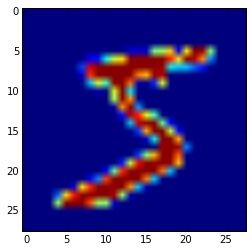

In [2]:
# Load sample of MNIST data.
filename = './MNIST_2000.csv'
X = numpy.loadtxt(filename, dtype='float32')
X, labels = X[:,1:], X[:,0].astype('uint8') # First column is label (0-9)
y = numpy.zeros((X.shape[0], 10), dtype='float32')
for i,label in enumerate(labels):
    y[i, label] = 1.0

# Show example image. 
plt.imshow(X[0,:].reshape(28,28))

# Split data into train, test.
X_train, y_train = X[:1000, :], y[:1000, :]
X_test, y_test = X[1000:, :], y[1000:, :]

# Create pylearn2 dataset objects.
from pylearn2.datasets.dense_design_matrix import DenseDesignMatrix
dataset_train = DenseDesignMatrix(X=X_train, y=X_train)
dataset_test = DenseDesignMatrix(X=X_test, y=X_test)
print dataset_train.X.shape

# Model
For this example, the outputs are real values in the range $[0,1]$, so we can use either a Sigmoid or Linear output. Pylearn2 chooses which cost function to use based on which output type we choose (KL-divergence or Squared Error, respectively). 

In [3]:
layers = []
nvis = dataset_train.X.shape[1] # Number of input features.
nhid = 100       # Hidden neurons in layers 0 and 2.
nbottleneck = 10 # Hidden neurons in bottleneck layer.

# Layer 0
istdev = 1.0/numpy.sqrt(nvis)         # Initial weights selected from normal distribution.
layer = pylearn2.models.mlp.RectifiedLinear(layer_name = 'h0', dim=nhid, istdev=istdev)
layers.append(layer)

# Layer 1: Bottleneck.
istdev = 1.0/numpy.sqrt(nhid)
layer = pylearn2.models.mlp.Tanh(layer_name = 'h1', dim=nbottleneck, istdev=istdev)
layers.append(layer)

# Layer 2
istdev = 1.0/numpy.sqrt(nhid)
layer = pylearn2.models.mlp.RectifiedLinear(layer_name = 'h2', dim=nhid, istdev=istdev)
layers.append(layer)


# Output layer.
layer = mlp.Linear(layer_name='y', dim=nvis, istdev=0.001)
layers.append(layer)

# MLP Model
model = pylearn2.models.mlp.MLP(layers, nvis=nvis, seed=36)

# Training Algorithm
Neural networks are typically trained using stochastic gradient descent (SGD). There are a number of tricks and parameter choices that go into this. 

In [4]:
# Cost/objective function.
cost = pylearn2.costs.mlp.Default()      # Defaults to Sum Squared Error for Linear output.
    
# Algorithm
args = {}
args['cost'] = cost
args['learning_rate'] = 0.01
args['batch_size']    = 100
args['learning_rule'] = pylearn2.training_algorithms.learning_rule.Momentum(init_momentum = 0.5)
args['monitoring_dataset'] = {'train':dataset_train, 'test':dataset_test}
args['termination_criterion'] = pylearn2.termination_criteria.EpochCounter(max_epochs=20)
algorithm = pylearn2.training_algorithms.sgd.SGD(**args)

# Train object.
filename_model = './model_mnist_autoencoder.pkl'
train = pylearn2.train.Train(dataset=dataset_train,
                             model=model,
                             algorithm=algorithm,
                             #extensions=extensions,
                             save_path=filename_model,
                             save_freq=5)

/home/pjsadows/venv/src/pylearn2/pylearn2/train.py:85: UserWarning: dataset has no yaml src, model won't know what data it was trained on
  "data it was trained on")


# Train model

In [5]:
# Run training loop.
train.main_loop()

Parameter and initial learning rate summary:
	h0_W: 0.00999999977648
	h0_b: 0.00999999977648
	h1_W: 0.00999999977648
	h1_b: 0.00999999977648
	h2_W: 0.00999999977648
	h2_b: 0.00999999977648
	y_W: 0.00999999977648
	y_b: 0.00999999977648
Compiling sgd_update...
Compiling sgd_update done. Time elapsed: 2.114670 seconds
compiling begin_record_entry...
compiling begin_record_entry done. Time elapsed: 0.832612 seconds
Monitored channels: 
	learning_rate
	momentum
	test_h0_col_norms_max
	test_h0_col_norms_mean
	test_h0_col_norms_min
	test_h0_max_x_max_u
	test_h0_max_x_mean_u
	test_h0_max_x_min_u
	test_h0_mean_x_max_u
	test_h0_mean_x_mean_u
	test_h0_mean_x_min_u
	test_h0_min_x_max_u
	test_h0_min_x_mean_u
	test_h0_min_x_min_u
	test_h0_range_x_max_u
	test_h0_range_x_mean_u
	test_h0_range_x_min_u
	test_h0_row_norms_max
	test_h0_row_norms_mean
	test_h0_row_norms_min
	test_h1_col_norms_max
	test_h1_col_norms_mean
	test_h1_col_norms_min
	test_h1_max_x_max_u
	test_h1_max_x_mean_u
	test_h1_max_x_min_u


/home/pjsadows/venv/src/pylearn2/pylearn2/monitor.py:572: UserWarning: Trained model saved without indicating yaml_src
  'indicating yaml_src')


Time this epoch: 0.029647 seconds
Monitoring step:
	Epochs seen: 6
	Batches seen: 60
	Examples seen: 6000
	learning_rate: 0.0100000007078
	momentum: 0.500000059605
	test_h0_col_norms_max: 1.08028900623
	test_h0_col_norms_mean: 1.00816738605
	test_h0_col_norms_min: 0.945087075233
	test_h0_max_x_max_u: 3.38641762733
	test_h0_max_x_mean_u: 1.02117538452
	test_h0_max_x_min_u: 0.0384449362755
	test_h0_mean_x_max_u: 1.1694715023
	test_h0_mean_x_mean_u: 0.297396689653
	test_h0_mean_x_min_u: 0.000588062452152
	test_h0_min_x_max_u: 0.0265699084848
	test_h0_min_x_mean_u: 0.000409010594012
	test_h0_min_x_min_u: 0.0
	test_h0_range_x_max_u: 3.37008213997
	test_h0_range_x_mean_u: 1.02076625824
	test_h0_range_x_min_u: 0.0384449362755
	test_h0_row_norms_max: 0.436615675688
	test_h0_row_norms_mean: 0.359222769737
	test_h0_row_norms_min: 0.280473798513
	test_h1_col_norms_max: 1.16177690029
	test_h1_col_norms_mean: 1.03568005562
	test_h1_col_norms_min: 0.911625623703
	test_h1_max_x_max_u: 0.98807901144
	

In [6]:
# Load saved model.
model = pickle.load(open(filename_model, 'r'))

# Print objective function after training.
channels = model.monitor.channels
print 'Train objective = %f' % channels['train_objective'].val_record[-1]
print 'Valid objective = %f' % channels['test_objective'].val_record[-1]

Train objective = 28.703981
Valid objective = 30.971039


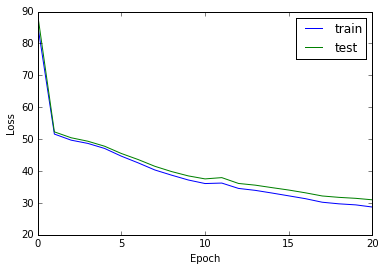

In [7]:
# Plot objective function.
plt.plot(channels['train_objective'].val_record, label='train')
plt.plot(channels['test_objective'].val_record, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#View autoencoded examples

In [41]:
# Create symbolic theano function to make predictions.
Xtheano = model.get_input_space().make_theano_batch()  # Loads entire dataset into memory.
Ytheano = model.fprop( Xtheano )
f = theano.function( [Xtheano], Ytheano )
yhat = f(dataset_test.X[:100,:])
print yhat.shape

# Create theano function the gives learned codes.
l0_theano = model.layers[0].fprop(Xtheano)
l1_theano = model.layers[1].fprop(l0_theano)
f_encode = theano.function([Xtheano], l1_theano)
encoded = f_encode(dataset_test.X[:100,:])
print encoded.shape

(100, 784)
(100, 10)


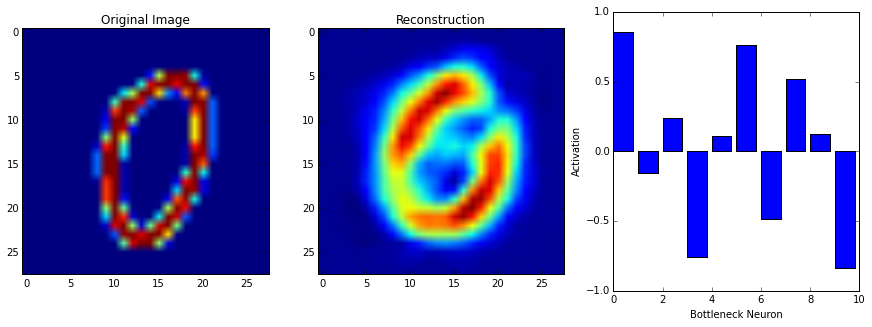

In [42]:
# View image reconstruction.
i = 0
plt.figure(1, figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(dataset_test.X[i,:].reshape(28,28))
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(yhat[i,:].reshape(28,28))
plt.title('Reconstruction')
plt.subplot(1,3,3)
plt.bar(range(encoded.shape[1]), encoded[i,:])
plt.ylabel('Activation')
plt.xlabel('Bottleneck Neuron')

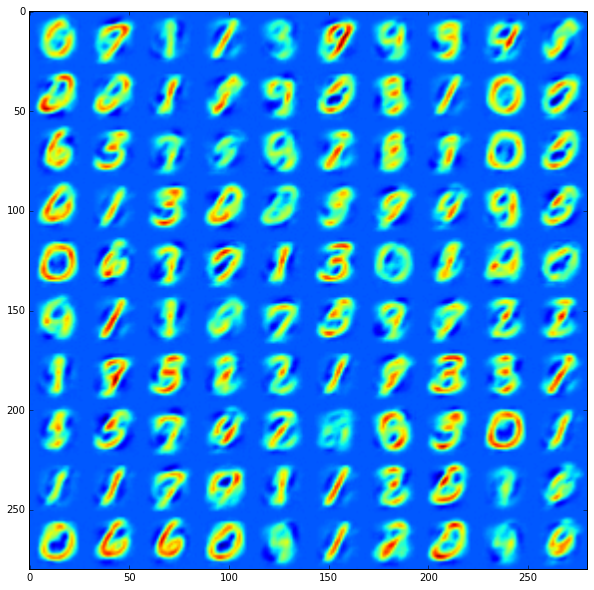

In [47]:
# Visualize the encoded characters.
plt.figure(1, figsize=(10,10))
width = 10
height = 10
for irow in range(height):
    start = irow * width
    row = numpy.hstack(tuple([yhat[i,:].reshape(28,28) for i in range(start, start+width)]))
    if irow == 0:
        img = row
    else:
        img = numpy.vstack((img, row))
plt.imshow(img)